In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("titanic.csv")

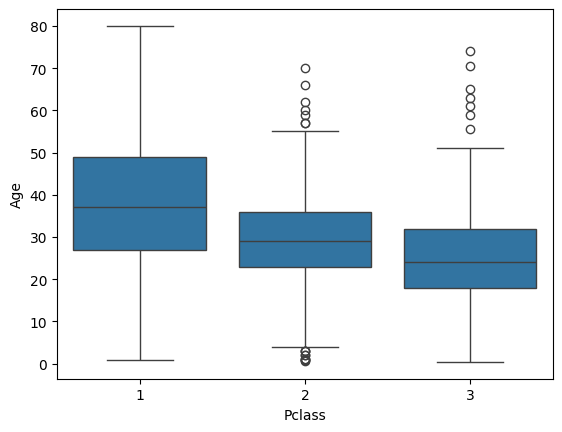

In [ ]:
# sns.countplot(x="Survived", data=df)
# plt.show()

# sns.countplot(x="Sex", hue="Survived", data=df)
# plt.show()

# sns.countplot(x="Pclass", hue="Survived", data=df)
# plt.show()

# sns.boxplot(x="Survived", y="Age", data=df)
# plt.show()

# sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
# plt.show()

# sns.displot(df['Age'])
# plt.show()

sns.boxplot(x="Pclass", y="Age", data=df)
plt.show()

# sns.countplot(x = "SibSp", data=df)
# plt.show()

Insert Seaborn immediately after loading the data
Before feature engineering
Never after model training

In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)

In [ ]:
# Handle missing values
df['Age'].fillna(df['Age'].median())
df['Embarked'].fillna(df['Embarked'].mode()[0])

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [ ]:
# Feature engineering
#Feature: FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

#Feature: IsAlone
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

#Feature: Age groups
from sklearn.impute import SimpleImputer

# Impute Age with median
age_imputer = SimpleImputer(strategy='median')
df['Age'] = age_imputer.fit_transform(df[['Age']])

# Recreate AgeGroup after imputation
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[0, 12, 20, 40, 60, 80],
    labels=[0, 1, 2, 3, 4]
)
df["AgeGroup"] = df["AgeGroup"].astype(int) #Encoding as an integer


# Here, pd.cut() splits the continuous "Age" into discrete bins/groups.

#Feature: Fare Band
df["FareBand"] = pd.qcut(df["Fare"], 4, labels=[0, 1, 2, 3])
# Here, pd.qcut() divides "Fare" into quartiles (4 equal parts).


In [ ]:
#Dropping redunant features
df.drop(columns=["SibSp", "Parch"], inplace=True)

In [ ]:
#Encode categorical variables
le_sex = LabelEncoder()
df["Sex"] = le_sex.fit_transform(df["Sex"])

le_embarked = LabelEncoder()
df["Embarked"] = le_embarked.fit_transform(df["Embarked"])


LabelEncoder from sklearn.preprocessing converts categorical labels into numeric labels.
"Sex" column: 'male' → 1, 'female' → 0
"Embarked" column: it will encode each unique value (e.g., 'C', 'Q', 'S') as 0, 1, 2 in alphabetical order.

In [ ]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,AgeGroup,FareBand
0,0,3,1,22.0,7.2500,2,2,0,2,0
1,1,1,0,38.0,71.2833,0,2,0,2,3
2,1,3,0,26.0,7.9250,2,1,1,2,1
3,1,1,0,35.0,53.1000,2,2,0,2,3
4,0,3,1,35.0,8.0500,2,1,1,2,1


In [ ]:
#Feature-Target split
X = df.drop("Survived", axis=1)
y = df["Survived"]

X = all input features
y = the label we want the model to predict

In [ ]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
#Feature Scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,AgeGroup,FareBand
0,0,3,1,22.0,7.2500,2,2,0,2,0
1,1,1,0,38.0,71.2833,0,2,0,2,3
2,1,3,0,26.0,7.9250,2,1,1,2,1
3,1,1,0,35.0,53.1000,2,2,0,2,3
4,0,3,1,35.0,8.0500,2,1,1,2,1


In [ ]:
df.isnull().sum()

In [ ]:
np.isnan(X_train).sum()

np.int64(0)

In [ ]:
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs"],
    "class_weight": [None, "balanced"]
}

log_reg = LogisticRegression(max_iter=1000)

grid = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...max_iter=1000)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...], 'class_weight': [None, 'balanced'], 'solver': ['lbfgs']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is

In [ ]:
best_model = grid.best_estimator_

In [ ]:
#Predictions
y_pred = best_model.predict(X_test)

In [ ]:
#Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", conf_matrix)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.8101
Confusion Matrix: [[90 20]
 [14 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84       110
           1       0.73      0.80      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.81      0.81      0.81       179

